In [0]:
from __future__ import print_function, division
from builtins import range, input

In [0]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from skimage.transform import resize

from datetime import datetime

import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

#from ipynb.fs.full.dlp_style1 import VGG16_AvgPool, unpreprocess, scale_img
#from ipynb.fs.full.dlp_style2 import gram_matrix, style_loss, minimize
from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


In [0]:
def VGG19_AvgPool(shape):
    vgg = VGG19(input_shape = shape, weights = 'imagenet', include_top = False)
    
    new_model = Sequential()
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
            new_model.add(AveragePooling2D())
        else:
            new_model.add(layer)
            
    return new_model


In [0]:
def VGG19_AvgPool_CutOff(shape, num_convs):
    if num_convs < 1 or num_convs > 13:
        print("num_convs must be in the range [1, 13]")
        return None
    
    model = VGG19_AvgPool(shape)
    new_model = Sequential()
    n = 0
    
    for layer in model.layers:
        if layer.__class__ == Conv2D:
            n += 1
        new_model.add(layer)
        if n >= num_convs:
            break
            
    return new_model

In [0]:
def unpreprocess(img):
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    
    return img

In [0]:
def scale_img(x):
    x = x-x.min()
    x = x / x.max()
    return x

In [0]:
def gram_matrix(img):
    X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
    G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
    return G

In [0]:
def style_loss(y, t):
    return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

In [0]:
def minimize(fn, epochs, batch_shape):
    t0 = datetime.now()
    losses = []
    x = np.random.randn(np.prod(batch_shape))
    for i in range(epochs):
        x, l, _ = fmin_l_bfgs_b(
            func = fn,
            x0 = x,
            maxfun = 20
        )
        x = np.clip(x, -127, 127)
        print("iter=%s, loss=%s" % (i, l))
        losses.append(l)
        
    print("duration:", datetime.now() - t0)
    plt.plot(losses)
    plt.show()
    
    newimg = x.reshape(*batch_shape)
    final_img = unpreprocess(newimg)
    return final_img[0]

In [0]:
from google.colab import files
files.upload()

Saving image28.jpg to image28.jpg


{'image28.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xdb\x00C\x01\x03\x04\x04\x05\x04\x05\t\x05\x05\t\x14\r\x0b\r\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\xff\xc0\x00\x11\x08\x01\x8c\x02\x80\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x1

In [0]:
def load_img_and_preprocess(path, shape=None):
    img = image.load_img(path, target_size=shape)
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    return x

In [0]:
content_img = load_img_and_preprocess('image28.jpg',)

h,w = content_img.shape[1:3]
style_img = load_img_and_preprocess('image13.jpg', (h, w))

batch_shape = content_img.shape
shape = content_img.shape[1:]

vgg = VGG19_AvgPool(shape)

vgg.summary()

content_model = Model(vgg.input, vgg.layers[13].get_output_at(0))
content_target = K.variable(content_model.predict(content_img))

symbolic_conv_outputs = [
    layer.get_output_at(1) for layer in vgg.layers \
    if layer.name.endswith('conv1')
]

symbolic_conv_outputs = symbolic_conv_outputs[:11]
style_model = Model(vgg.input, symbolic_conv_outputs)

style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

style_weights = [1, 3, 5, 6, 7]

loss = K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
    loss += w * style_loss(symbolic[0], actual[0])

grads = K.gradients(loss, vgg.input)

get_loss_and_grads = K.function(inputs = [vgg.input], outputs = [loss] + grads)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 396, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 396, 640, 64)      36928     
_________________________________________________________________
average_pooling2d_6 (Average (None, 198, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 198, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 198, 320, 128)     147584    
_________________________________________________________________
average_pooling2d_7 (Average (None, 99, 160, 128)      0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 99, 160, 256)     

In [0]:
def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)


iter=0, loss=134469.703125
iter=1, loss=87630.640625
iter=2, loss=71871.671875
iter=3, loss=62691.0859375
iter=4, loss=56650.3828125
iter=5, loss=52512.75
iter=6, loss=49447.703125
iter=7, loss=46983.91015625
iter=8, loss=45038.359375
iter=9, loss=43432.16796875
duration: 0:47:02.140334


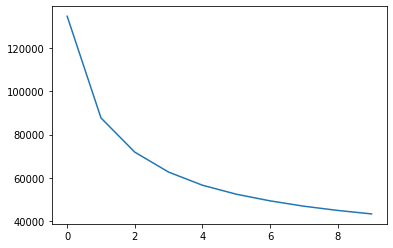

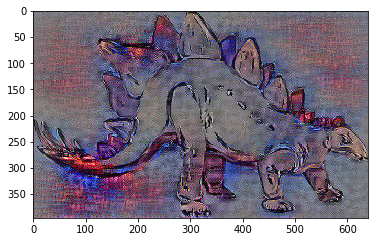

In [0]:
final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(scale_img(final_img))
plt.show()